In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

## 1) Dataset

In [2]:
"""#Load Dataset
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)


#Prepare X_train, y_train, X_test, y_test
composed_transform=transforms.Compose([transforms.ToTensor()])
X_train=[]
y_train=[]
for i in range(len(train_dataset)):
    X_train.append(torch.flatten(composed_transform(train_dataset[i][0]))) # for normal NN
    #X_train.append(composed_transform(train_dataset[i][0]).squeeze(0)) # for convolution
    y_train.append(train_dataset[i][0])

X_test=[]
y_test=[]
for i in range(len(test_dataset)):
    X_test.append(composed_transform(test_dataset[i][0]).squeeze(0))
    y_test.append(test_dataset[i][0])
    
print(len(y_train),len(y_test))"""

"#Load Dataset\ntrain_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)\ntest_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)\n\n\n#Prepare X_train, y_train, X_test, y_test\ncomposed_transform=transforms.Compose([transforms.ToTensor()])\nX_train=[]\ny_train=[]\nfor i in range(len(train_dataset)):\n    X_train.append(torch.flatten(composed_transform(train_dataset[i][0]))) # for normal NN\n    #X_train.append(composed_transform(train_dataset[i][0]).squeeze(0)) # for convolution\n    y_train.append(train_dataset[i][0])\n\nX_test=[]\ny_test=[]\nfor i in range(len(test_dataset)):\n    X_test.append(composed_transform(test_dataset[i][0]).squeeze(0))\n    y_test.append(test_dataset[i][0])\n    \nprint(len(y_train),len(y_test))"

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', cache=True)

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 784), (52500,), (17500, 784), (17500,))

## 2) Models

In [51]:
class BasicNet(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.soft = nn.Softmax()
        self.relu= nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.name="BasicNet"

        print('Network initialized')
        
    def forward(self, input, additional_out=False):
        x=input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.out(x)
        x = nn.functional.softmax(x, dim=-1)
        return x

## 3) Training

### 3.1) Initialization

In [53]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_function = nn.CrossEntropyLoss()


from skorch.callbacks import EarlyStopping

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=500,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)


from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=BasicNet,
    module__Ni= 784,
    module__Nh1 = 128,
    module__Nh2 = 128,
    module__No = 10,
    max_epochs=50,
    
    device=device,  # uncomment this to train with CUDA
    #lr=0.1,
    optimizer = optim.SGD,
    optimizer__lr=0.01,
    #optimizer__weight_decay=1e-5, #L2 norm
    #criterion=nn.CrossEntropyLoss(),
    callbacks = [my_early],
    #verbose=0
)

Training device: cuda


In [54]:
net.fit(X_train, y_train)

Network initialized
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2462       0.5161        2.1453  1.2152
      2        1.8413       0.7158        1.4106  1.0974
      3        1.0083       0.8110        0.7570  1.1002
      4        0.6310       0.8492        0.5651  1.1049
      5        0.5035       0.8683        0.4803  1.1111
      6        0.4402       0.8786        0.4318  1.0911
      7        0.4019       0.8866        0.4003  1.1360
      8        0.3761       0.8929        0.3782  1.1425
      9        0.3571       0.8975        0.3616  1.1372
     10        0.3422       0.9012        0.3483  1.1055
     11        0.3299       0.9054        0.3372  1.2223
     12        0.3192       0.9084        0.3275  1.1843
     13        0.3098       0.9105        0.3189  1.2370
     14        0.3012       0.9132        0.3110  1.2324
     15        0.2933       0.9155        0.3039  1.0886
     16    

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BasicNet(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (out): Linear(in_features=128, out_features=10, bias=True)
    (soft): Softmax(dim=None)
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  ),
)

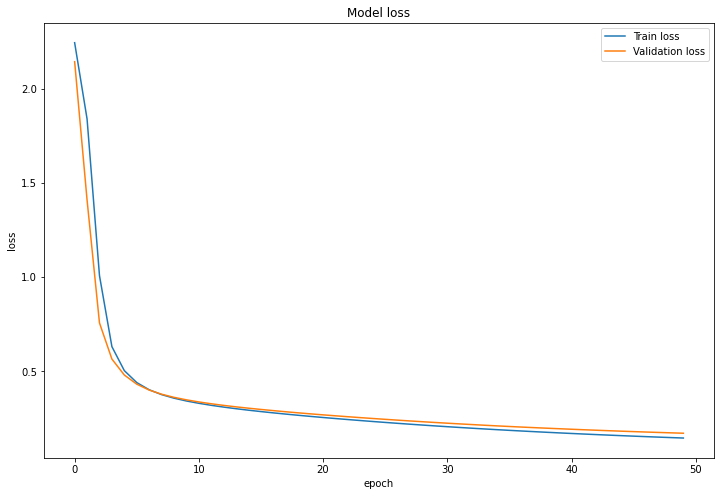

In [55]:
import datetime
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
#plt.savefig("models/"+save_name+"_Losses", dpi=400)
plt.show()

In [56]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(X_test)
accuracy_score(y_test, y_pred)

0.9497142857142857